Preprocessing function 

In [1]:
import re
import pandas as pd

def preprocess_ocr_text(text) -> str:
    if not isinstance(text, str):
        return ""
    # Replace known OCR noise characters
    text = text.replace("â€œ", "").replace("â€", "").replace("â€˜", "").replace("â€™", "'")

    # Remove unwanted symbols
    text = re.sub(r"(â|Â|¢|§|«|©|®|€|“|”|‘|’|™|…|_|=||•|—|–|@|%|<|>|\\|\||~|`)", "", text)

    # Fix common formatting issues
    text = re.sub(r"(\d)(tab/s|tablet[s]?|cap[s]?|capsule[s]?)", r"\1 tablet", text, flags=re.IGNORECASE)
    text = re.sub(r"(\d)(times)", r"\1 times", text, flags=re.IGNORECASE)
    text = re.sub(r"(\d)\s*x\s*(a|per)?\s*day", r"\1 times a day", text, flags=re.IGNORECASE)

    # Normalize known expressions
    replacements = {
        "twice a day": "2 times a day",
        "three times daily": "3 times a day",
        "when necessary": "when needed",
        "when required": "when needed",
    }

    for wrong, correct in replacements.items():
        text = re.sub(rf"\b{wrong}\b", correct, text, flags=re.IGNORECASE)

    #remove irrelevant data
    lines = text.splitlines()
    cleaned = []

    for line in lines:
        # Skip if line contains clinic/address info
        if any(x in line for x in ["clinic", "centre", "hospital", "#", "blk", "building", "road", "s "]):
            continue
        # Skip prices and quantities
        if re.search(r"\bqty\b|\bprice\b|\$\d+|\d+\.\d{2}", line):
            continue
        cleaned.append(line)
    

    # Remove extra whitespace
    text = re.sub(r"\s+", " ", text)

    return text.strip()

df = pd.read_csv("ocr2_output_cleaned.csv")
df["extracted_text"] = df["extracted_text"].apply(preprocess_ocr_text)
df.to_csv("cleaned_ocr_labels2.csv", index=False)

#do not change to lowercase as it will affect the keyword matching later for medication!

    


labeling of the text

In [ ]:
import pandas as pd
import json
import re

# Define your CSV file and column
csv_file = "cleaned_ocr_labels2.csv"
column_name = "extracted_text"

# Define keyword groups for automatic tagging
keywords1 = {
    "DOSAGE": ["tablet", "tablets", "teblet", "tab", "tabs", "tab/s","cap/s","cap", "capsule", "capsules"],
    "FREQUENCY": ["times", "time", "hour", "hours","hourly","morning", "evening", "afternoon", "bedtime", "night"]
}

keywords2 = {
    "FREQUENCY": ["once", "twice"],
    "INSTRUCTION": ["when","needed", "after", "use","before", "after", "with", "without", "meal", "meals", "food", "swallow","chew"],
    "NOTE" : ["fever","pain", "cough", "cold", "flu", "runny", "allergy", "infection", "inflammation", "swelling", "sore throat", "headache", "nausea","gastric", "drowsiness", "vomiting", "diarrhea", "constipation", "rash", "itching", "fatigue", "dizziness"]
}


# split sentence into tokens using regex
def tokenize(text):
    return re.findall(r"\b\w+(?:/\w+)?\b", text.lower())

# Auto-label function (basic BIO tagging)
def auto_label(tokens):
    labels = ["O"] * len(tokens)

    quantity_words = {
        "1", "2", "3", "4", "5", "10", "one", "two", "three", "four", "five", "half", "quarter"
    }

    # Collect known keywords
    known_keywords = set()
    for group in [*keywords1.values(), *keywords2.values()]:
        known_keywords.update(word.lower() for word in group)

    #MEDICATION_NAME tagging to tag the first unknown word
    for i, token in enumerate(tokens):
        token_lower = token.lower()
        if (
            labels[i] == "O"
            and token_lower not in known_keywords
            and token_lower.isalpha()
            and len(token) > 3
        ):
            labels[i] = "B-MEDICATION_NAME"
            break  # only tag the first one

    #DOSAGE tagging
    dosage_candidates = [
        i for i in range(1, len(tokens))
        if tokens[i].lower() in keywords1["DOSAGE"] and tokens[i - 1].lower() in quantity_words
    ]

    if len(dosage_candidates) == 1:
        i = dosage_candidates[0]
        labels[i - 1] = "B-DOSAGE"
        labels[i] = "I-DOSAGE"
    elif len(dosage_candidates) >= 2:
        i = dosage_candidates[1]  # tag only the second
        labels[i - 1] = "B-DOSAGE"
        labels[i] = "I-DOSAGE"

    #FREQUENCY tagging
    for i in range(1, len(tokens)):
        if (
            tokens[i].lower() in keywords1["FREQUENCY"] and 
            tokens[i - 1].lower()
        ):
            labels[i - 1] = "B-FREQUENCY"
            labels[i] = "I-FREQUENCY"

    #keywords2 tagging
    for i, token in enumerate(tokens):
        token_lower = token.lower()
        for label, keyword_list in keywords2.items():
            if token_lower in keyword_list and labels[i] == "O":
                labels[i] = f"B-{label.upper()}"
                if (
                    i + 1 < len(tokens) and 
                    tokens[i + 1].lower() in keyword_list
                ):
                    labels[i + 1] = f"I-{label.upper()}"

    return labels



# Load CSV
df = pd.read_csv(csv_file)

# Clean nulls and whitespace
df = df[df[column_name].notnull()]
df[column_name] = df[column_name].astype(str).str.strip()

# Build token-label pairs
data = []
for text in df[column_name]:
    tokens = tokenize(text)
    labels = auto_label(tokens)
    data.append({"tokens": tokens, "labels": labels})

# Save to JSON
with open("auto_labeled_ner_data2.json", "w") as f:
    json.dump(data, f, indent=2)

print("Auto-labeling complete!")




✅ Auto-labeling complete! Saved to auto_labeled_ner_data.json


Ran through the data manually to check and edit the labels.
convert JSON to CSV below for easier editing 

In [ ]:
import json
import pandas as pd

# Load the JSON file
with open("auto_labeled_ner_data3.json", "r") as f:
    data = json.load(f)

# Flatten into token-label pairs
rows = []
for entry in data:
    tokens = entry["tokens"]
    labels = entry["labels"]
    rows.extend(zip(tokens, labels))

# Create DataFrame
df = pd.DataFrame(rows, columns=["Token", "Label"])

# Save to CSV
df.to_csv("auto_labeled_ner_data3_flat.csv", index=False)

print("Saved as auto_labeled_ner_data3_flat.csv")


Saved as auto_labeled_ner_data2_flat.csv


convert from CSV to JSON for training of model. A new block need to start from medication first

In [5]:
import json

# Path to your raw data
input_path = r"C:\Users\prisc\OneDrive\Desktop\Github\MediMind\ml\auto_labeled_ner_data3_flat.csv"
output_path = r"C:\Users\prisc\OneDrive\Desktop\Github\MediMind\ml\clean_clean.json"

# Parse and group tokens by B-MEDICATION_NAME start
data_blocks = []
current_tokens = []
current_labels = []

with open(input_path, "r", encoding="utf-8") as f:
    for line in f:
        line = line.strip()
        if not line or line.lower().startswith("token"):  # Skip empty lines/header
            continue
        try:
            token, label = line.split(",", 1)
            token = token.strip()
            label = label.strip().upper()

            if label == "B-MEDICATION_NAME":
                # Start new block if one already exists
                if current_tokens:
                    data_blocks.append({
                        "tokens": current_tokens,
                        "labels": current_labels
                    })
                    current_tokens = []
                    current_labels = []

            current_tokens.append(token)
            current_labels.append(label)
        except ValueError:
            continue

# Append final group
if current_tokens:
    data_blocks.append({
        "tokens": current_tokens,
        "labels": current_labels
    })

# Save as JSON
with open(output_path, "w", encoding="utf-8") as out:
    json.dump(data_blocks, out, indent=2)

print(f"✅ Converted {len(data_blocks)} medication blocks. Saved to: {output_path}")

✅ Converted 84 medication blocks. Saved to: C:\Users\prisc\OneDrive\Desktop\Github\MediMind\ml\clean_clean.json


In [ ]:
!pip install transformers datasets seqeval scikit-learn
!pip install "accelerate>=0.26.0"
!pip install --upgrade transformers

!pip install torchvision
!pip install torch


Defaulting to user installation because normal site-packages is not writeable
  Using cached transformers-4.54.1-py3-none-any.whl.metadata (41 kB)
Using cached transformers-4.54.1-py3-none-any.whl (11.2 MB)
   ---------------------------------------- 0.0/2.5 MB ? eta -:--:--
   ------------------------- -------------- 1.6/2.5 MB 8.7 MB/s eta 0:00:01
   ---------------------------------------- 2.5/2.5 MB 8.4 MB/s eta 0:00:00



[notice] A new release of pip is available: 24.3.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [11]:
import torch
import torchvision

print(torch.__version__)
print(torchvision.__version__)


2.7.1+cpu
0.22.1+cpu


In [12]:
import pandas as pd

# Load CSV
df = pd.read_csv("auto_labeled_ner_data3_flat.csv")

# Clean 'Label' column
df["Label"] = df["Label"].astype(str).str.upper().replace("O", "O")

# Save cleaned CSV
df.to_csv("auto_labeled_ner_data3_flat_cleaned.csv", index=False)

print("✅ Labels cleaned and saved to auto_labeled_ner_data3_flat_cleaned.csv")


✅ Labels cleaned and saved to auto_labeled_ner_data3_flat_cleaned.csv


training BERT model 

In [ ]:
import json
from datasets import Dataset
from transformers import BertTokenizerFast
from transformers import BertForTokenClassification
from transformers import TrainingArguments, Trainer
from transformers import pipeline

with open("clean_clean.json", "r") as f:
    data = json.load(f)

dataset = Dataset.from_list(data)
dataset

#create a label list
label_list = sorted({label for d in data for label in d["labels"]})
label_to_id = {label: i for i, label in enumerate(label_list)}
id_to_label = {i: label for label, i in label_to_id.items()}

print("Label list:", label_list)

#tokenise and align labels
tokenizer = BertTokenizerFast.from_pretrained("bert-base-cased")

def tokenize_and_align_labels(example):
    tokenized_inputs = tokenizer(example["tokens"], is_split_into_words=True, padding='max_length',  truncation=True)
    word_ids = tokenized_inputs.word_ids()
    
    labels = []
    previous_word_idx = None
    for word_idx in word_ids:
        if word_idx is None:
            labels.append(-100)
        elif word_idx != previous_word_idx:
            labels.append(label_to_id[example["labels"][word_idx]])
        else:
            labels.append(label_to_id[example["labels"][word_idx]])
        previous_word_idx = word_idx

    tokenized_inputs["labels"] = labels
    return tokenized_inputs

tokenized_dataset = dataset.map(tokenize_and_align_labels)

#load the model with tokenized labels
model = BertForTokenClassification.from_pretrained("bert-base-cased", num_labels=11)

#train the model
training_args = TrainingArguments(
    output_dir="./ner_model",
    save_safetensors=False
    per_device_train_batch_size=8,
    num_train_epochs=3,
    logging_dir="./logs",
    logging_strategy="epoch"
    
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset,
    tokenizer=tokenizer,

)

trainer.train()

#save the model
trainer.save_model("./ner_medication_model")
tokenizer.save_pretrained("./ner_medication_model")


#inference testing
ner_pipe = pipeline("ner", model="./ner_medication_model", tokenizer="./ner_medication_model", aggregation_strategy="simple")

text = "Take 2 tablets 3 times a day after food"
results = ner_pipe(text)

for entity in results:
    print(entity["word"], "→", entity["entity_group"])

Label list: ['B-DOSAGE', 'B-FREQUENCY', 'B-INSTRUCTION', 'B-MEDICATION_NAME', 'B-NOTE', 'I-DOSAGE', 'I-FREQUENCY', 'I-INSTRUCTION', 'I-MEDICATION_NAME', 'I-NOTE', 'O']


Map:   0%|          | 0/84 [00:00<?, ? examples/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\prisc\AppData\Local\Temp\ipykernel_25836\1794456460.py:57: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
C:\Users\prisc\AppData\Roaming\Python\Python313\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
C:\Users\prisc\AppData\Roaming\Python\Python313\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call

Step,Training Loss
11,1.398300
22,0.663900
33,0.422100


Device set to use cpu


Take → LABEL_10
2 → LABEL_0
tablets → LABEL_10
3 → LABEL_1
times → LABEL_6
a day → LABEL_10
after → LABEL_2
food → LABEL_7


C:\Users\prisc\AppData\Roaming\Python\Python313\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Map:   0%|          | 0/67 [00:00<?, ? examples/s]

Map:   0%|          | 0/17 [00:00<?, ? examples/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\prisc\AppData\Local\Temp\ipykernel_14364\1723969018.py:104: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,1.471900,1.006111,0.677741,0.648352,0.368750,0.470120
2,0.664400,0.523672,0.870432,0.754190,0.843750,0.796460
3,0.343200,0.447002,0.882060,0.817610,0.812500,0.815047
4,0.202700,0.490336,0.873754,0.816456,0.806250,0.811321
5,0.115300,0.445494,0.882060,0.734043,0.862500,0.793103
6,0.073000,0.534036,0.878738,0.802395,0.837500,0.819572
7,0.068000,0.512390,0.877076,0.761364,0.837500,0.797619
8,0.044300,0.500290,0.887043,0.782353,0.831250,0.806061
9,0.024300,0.540665,0.882060,0.768362,0.850000,0.807122
10,0.026100,0.554192,0.882060,0.784884,0.843750,0.813253


C:\Users\prisc\AppData\Roaming\Python\Python313\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
C:\Users\prisc\AppData\Roaming\Python\Python313\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
C:\Users\prisc\AppData\Roaming\Python\Python313\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
C:\Users\prisc\AppData\Roaming\Python\Python313\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*ar


 Evaluation Metrics:
eval_loss: 0.6851
eval_accuracy: 0.8953
eval_precision: 0.7709
eval_recall: 0.8625
eval_f1: 0.8142
eval_runtime: 7.3713
eval_samples_per_second: 2.3060
eval_steps_per_second: 0.4070
epoch: 50.0000


Device set to use cpu



 Inference Output:
2 → DOSAGE
3 → DOSAGE
times → MEDICATION_NAME
after → FREQUENCY
food → MEDICATION_NAME


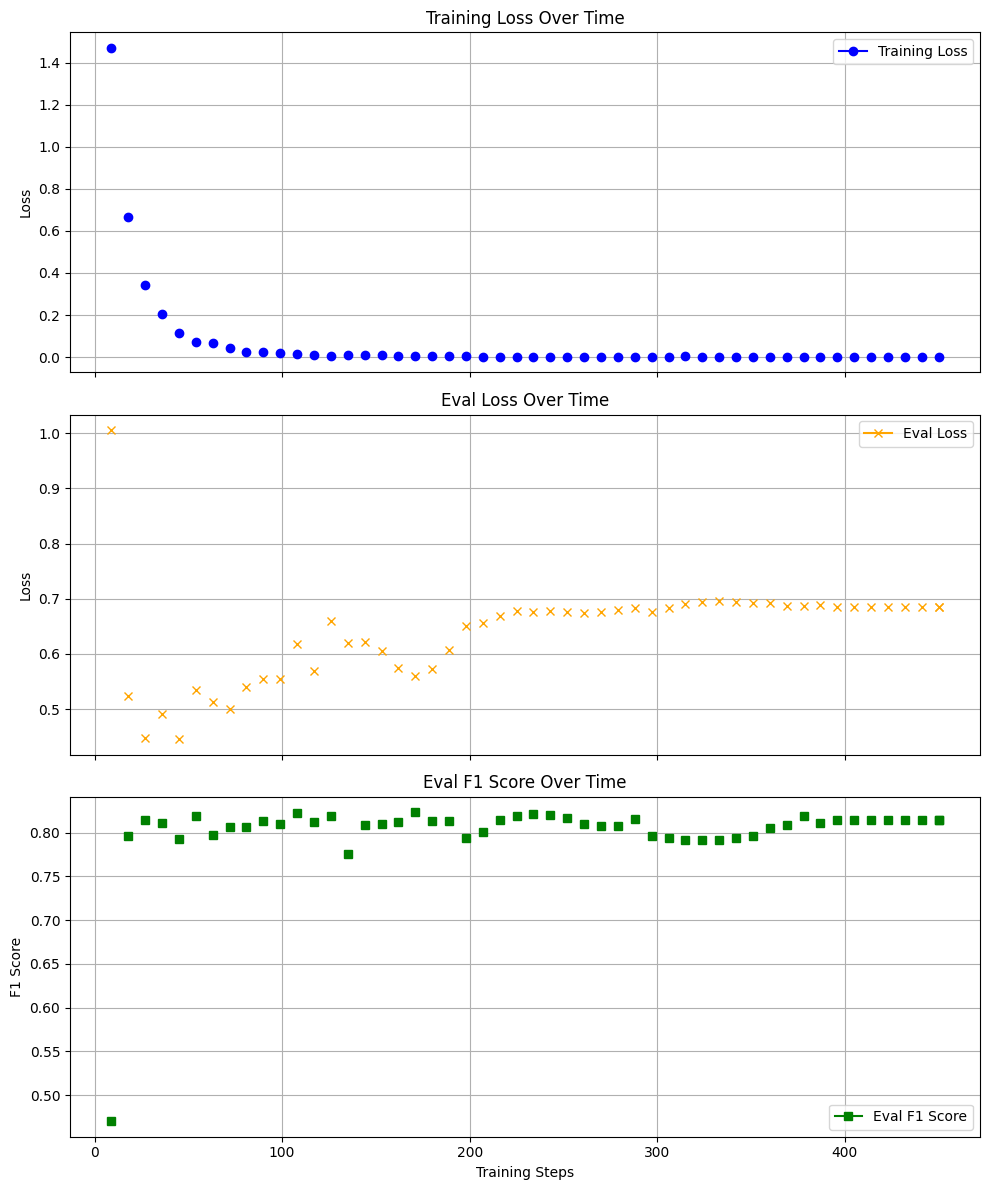

In [ ]:
import json
from datasets import Dataset, DatasetDict
from transformers import BertTokenizerFast, BertForTokenClassification
from transformers import TrainingArguments, Trainer
from transformers import pipeline
from sklearn.model_selection import train_test_split
from seqeval.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import pandas as pd

#Load Data 
with open("clean_clean.json", "r") as f:
    data = json.load(f)

#train test split 
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)
dataset = DatasetDict({
    "train": Dataset.from_list(train_data),
    "test": Dataset.from_list(test_data)
})

#Create Label Mapping to number labels for training
label_list = [
    "B-DOSAGE", "I-DOSAGE",
    "B-FREQUENCY", "I-FREQUENCY",
    "B-INSTRUCTION", "I-INSTRUCTION",
    "B-MEDICATION_NAME", "I-MEDICATION_NAME",
    "B-NOTE", "I-NOTE",
    "O"
]

label_to_id = {label: i for i, label in enumerate(label_list)}
id_to_label = {i: label for label, i in label_to_id.items()}
num_labels = len(label_list)

# pre-trained tokenizer to tokenize the text with ids
tokenizer = BertTokenizerFast.from_pretrained("bert-base-cased")
 
# Tokenization and label alignment
def tokenize_and_align_labels(example):
    tokenized_inputs = tokenizer(example["tokens"], is_split_into_words=True, padding='max_length', truncation=True)
    word_ids = tokenized_inputs.word_ids()

    labels = []
    previous_word_idx = None
    for word_idx in word_ids:
        if word_idx is None:
            labels.append(-100)
        else:
            labels.append(label_to_id[example["labels"][word_idx]])
        previous_word_idx = word_idx

    tokenized_inputs["labels"] = labels
    return tokenized_inputs

tokenized_datasets = dataset.map(tokenize_and_align_labels)

# Load model
model = BertForTokenClassification.from_pretrained(
    "bert-base-cased",
    num_labels=num_labels,
    id2label=id_to_label,
    label2id=label_to_id
)

# Compute metrics for evaluation
def compute_metrics(p):
    predictions, labels = p
    predictions = predictions.argmax(axis=-1)

    true_labels = []
    true_predictions = []

    for pred, label in zip(predictions, labels):
        current_preds = []
        current_labels = []
        for p_i, l_i in zip(pred, label):
            if l_i != -100:
                current_preds.append(id_to_label[p_i])
                current_labels.append(id_to_label[l_i])
        true_predictions.append(current_preds)
        true_labels.append(current_labels)

    return {
        "accuracy": accuracy_score(true_labels, true_predictions),
        "precision": precision_score(true_labels, true_predictions),
        "recall": recall_score(true_labels, true_predictions),
        "f1": f1_score(true_labels, true_predictions),
    }

#Training set up
training_args = TrainingArguments(
    output_dir="./ner_model1",
    save_safetensors=False,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=50,
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_dir="./logs",
    logging_strategy="epoch"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["test"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)


#Train Model 
trainer.train()

#Save Model 
model_path = "./ner_medication_model"
trainer.save_model(model_path)
tokenizer.save_pretrained(model_path)

#Evaluate on test Set 
eval_results = trainer.evaluate()
print("\n Evaluation Metrics:")
for k, v in eval_results.items():
    print(f"{k}: {v:.4f}")

#Inference Example 
ner_pipe = pipeline("ner", model=model_path, tokenizer=model_path, aggregation_strategy="simple")
text = "Take 2 tablets 3 times a day after food"
results = ner_pipe(text)
print("\n Inference Output:")
for entity in results:
    print(f"{entity['word']} → {entity['entity_group']}")

#evaluation output
logs = trainer.state.log_history
df_logs = pd.DataFrame(logs)
print(df_logs)

# Plot 3 graphs
if "step" in df_logs.columns:
    fig, axs = plt.subplots(3, 1, figsize=(10, 12), sharex=True)

    # Training Loss
    if "loss" in df_logs.columns:
        axs[0].plot(df_logs["step"], df_logs["loss"], label="Training Loss", marker='o', color='blue')
        axs[0].set_title("Training Loss Over Time")
        axs[0].set_ylabel("Loss")
        axs[0].legend()
        axs[0].grid(True)

    # Eval Loss
    if "eval_loss" in df_logs.columns:
        axs[1].plot(df_logs["step"], df_logs["eval_loss"], label="Eval Loss", marker='x', color='orange')
        axs[1].set_title("Eval Loss Over Time")
        axs[1].set_ylabel("Loss")
        axs[1].legend()
        axs[1].grid(True)

    # Eval F1 Score
    if "eval_f1" in df_logs.columns:
        axs[2].plot(df_logs["step"], df_logs["eval_f1"], label="Eval F1 Score", marker='s', color='green')
        axs[2].set_title("Eval F1 Score Over Time")
        axs[2].set_ylabel("F1 Score")
        axs[2].set_xlabel("Training Steps")
        axs[2].legend()
        axs[2].grid(True)

    plt.tight_layout()
    plt.show()
else:
    print("No 'step' column found in logs to plot.")



In [8]:
from transformers import pipeline
from collections import defaultdict

# Load BERT NER pipeline
ner_pipe = pipeline(
    "ner",
    model="./ner_medication_model",
    tokenizer="./ner_medication_model",
    aggregation_strategy="simple"  # ensures "2 tablets" is treated as one
)

text = "Take 2 tablets 3 times a day after food loratadine may cause drowsiness"

# Run inference
results = ner_pipe(text)

# Group output by entity type 
grouped_output = defaultdict(list)
for entity in results:
    label = entity["entity_group"]  # e.g. B-DOSAGE
    word = entity["word"]

    # Normalize label (strip B- or I- prefixes)
    base_label = label.split("-")[-1] if "-" in label else label
    grouped_output[base_label].append(word)

# results to display in console here to fit into the format that required to show in mobile
def clean_prediction(grouped_output):
    final = {}

    # Medication name: only take the first word
    meds = grouped_output.get("MEDICATION_NAME", [])
    if meds:
        final["medication_name"] = meds[0]

    # Dosage: take only the first numeric token, or fallback to first token
    dosages = grouped_output.get("DOSAGE", [])
    filtered = [w for w in dosages if w.isnumeric()]
    if filtered:
        final["dosage"] = filtered[0]
    elif dosages:
        final["dosage"] = dosages[0]

    # Frequency, Instruction, Note: keep full phrases
    for field in ["FREQUENCY", "INSTRUCTION", "NOTE"]:
        value = " ".join(grouped_output.get(field, []))
        if value:
            final[field.lower()] = value

    return final

# Apply postprocessing
final_output = clean_prediction(grouped_output)

# Print results
for k, v in final_output.items():
    print(f"{k.capitalize()}: {v}")

#Convert to JSON string
json_output = json.dumps(final_output, indent=4)
print("JSON Output:")
print(json_output)
with open("ner_output.json", "w") as f:
    f.write(json_output)


Device set to use cpu


Medication_name: times
Dosage: 2
Frequency: after ##rata
Instruction: d ##rows ##iness
JSON Output:
{
    "medication_name": "times",
    "dosage": "2",
    "frequency": "after ##rata",
    "instruction": "d ##rows ##iness"
}
